# ACTIVIDAD 3 (GRUPAL): REDES NEURONALES RECURRENTES (RNN)

---

En esta actividad grupal, vamos a utilizar las RNN para identificar la intensidad de odio en mensajes escritos en las redes sociales. Esta actividad forma parte del proyecto transversal del Máster, ¡así que seguro que ya estás familiarizado/a con el dataset!

Por sencillez, se adjunta un documento csv que es una versión resumida del dataset original del proyecto transversal. En este dataset, solo se incluyen los mensajes que han sido catalogados como contenedores de odio. También se han eliminado las features innecesarias para este trabajo simplemente para hacer todo el proceso más rápido computacionalmente hablando.

El dataset a utilizar consiste en 12280 mensajes de odio. Los mensajes pueden pertenecer a cinco categorias (numeradadas del 1 al 5), siendo 1 la menor intensidadd y 5 la mayor intensidad de odio del mensaje. El dataset ya ha sido procesado para eliminar ciertos caracteres que podrían darte problemas y para utilizar una codificación más amigable.

Empezamos, como siempre, incluyendo todo lo que vamos a necesitar. Según lo que vayas a hacer, es posible que necesites incluir alguna librería extra.

In [101]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargamos el dataset. Lo encontrarás adjunto a este Notebook, al descargar la actividad del Campus Virtual.

In [ ]:
# Leemos el fichero
data = pd.read_csv('dataset.csv', sep=";", encoding='utf-8')
# Mostramos las 5 primeras filas
data.head()

,CONTENIDO A ANALIZAR,INTENSIDAD
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Cambiamos el nombre de las features para hacer su manejo más amigable:

In [ ]:
data = data.rename(columns={'CONTENIDO A ANALIZAR': 'mensaje', 'INTENSIDAD': 'intensidad'})
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Mostramos información básica para saber a qué nos enfrentamos:

In [ ]:
data.shape

(12279, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensaje     12279 non-null  object
 1   intensidad  12279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ KB


Mostramos ahora la distribución de mensajes de acuerdo a su intensidad. Verás rápidamente que estamos en problemas: hay un gran desbalanceo.

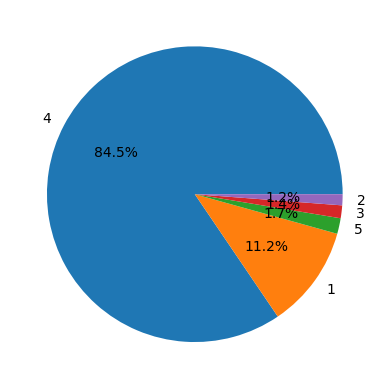

In [ ]:
plt.pie(data['intensidad'].value_counts().values,
        labels = data['intensidad'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Para hacer todo más sencillo y evitar asociaciones indeseadas, vamos a trabajar solo con minúsculas. Además, quitamos los signos de puntuación de los mensajes

In [ ]:
# Convertimos a minúsculas
data['mensaje'] = data['mensaje'].map(lambda x: x.lower())

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
data['mensaje'] = data['mensaje'].map(eliminar_signos)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso el supremo se dedi...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,preguntárselo al fracasado media carrera en 6 ...,4


Eliminamos las "stopwords" o palabras vacías. Las stopwords son palabras comunes que, en general, no contienen información relevante para el análisis de texto y suelen ser filtradas antes de procesar los datos. Ejemplos típicos de stopwords en español son: "el", "la", "los", "las", "un", "una", "de", "y", "o", etc.

In [ ]:
# Obtenemos las stopwords en español
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Definimos una función para eliminar stopwords y lematizar
def filtrar_palabras(texto):
    palabras_filtradas = []
    for palabra in texto.split():
        if palabra not in stop_words:
            palabra_lema = lemmatizer.lemmatize(palabra)
            palabras_filtradas.append(palabra_lema)
    return ' '.join(palabras_filtradas)

# Aplicamos la función
data['mensaje'] = data['mensaje'].apply(filtrar_palabras)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 meses...,4


Creamos los conjuntos de entrenamiento y de test:

In [ ]:
X = data['mensaje']
y = data['intensidad']

# Dividimos el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos a numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# ajuste de las etiquetas para el entrenamiento
y_train = np.array([(value-1) for value in y_train])
y_test = np.array([(value-1) for value in y_test])

# Creamos datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

Mostramos un mensaje y su intensidad, simplemente para ver que todo va bien:

In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy())
  print('nivel de odio: ', inte.numpy())

mensaje:  b'tarado abascal dice gran lider tarado trump'
nivel de odio:  3


Mezclamos los datos de forma aleatoria:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy()[:3])
  print()
  print('nivel de odio: ', inte.numpy()[:3])

mensaje:  [b'gentuza debe ser expulsada dejado entrar encarcelados cargando espa\xc3\xb1a'
 b'pserranooceja tipo publicidad sitio p\xc3\xbablico parece repugnante'
 b'menos patri\xc3\xb3tico robar multar empresas aut\xc3\xb3nomos ciudadanos mantener gobierno clase pol\xc3\xad\xc2\xadtica hdlgp']

nivel de odio:  [3 0 3]


Definimos y configuramos un codificador de texto utilizando la capa TextVectorization

In [ ]:
# Empezamos definiendo el tamaño del vocabulario
tamaño_vocabulario = 9000

# Creamos una capa de vectorización de texto
vectorizador = tf.keras.layers.TextVectorization(
    max_tokens=tamaño_vocabulario
)

# Se extraen solo los textos del conjunto de datos de entrenamiento
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de datos de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador.adapt(dataset_texto)

In [ ]:
# Obtenemos el vocabulario aprendido por la capa de vectorización
vocabulario = np.array(vectorizador.get_vocabulary())

# Mostramos las primeras 20 palabras del vocabulario
primeras_20_palabras = vocabulario[:20]
primeras_20_palabras

array(['', '[UNK]', 'si', 'mierda', 'puta', 'ser', 'asco', 'gobierno',
       'panfleto', 'q', 'españa', 'paí\xads', 'gente', 'vergüenza',
       'gentuza', 'vaya', 'basura', 'va', 'gilipollas', 'solo'],
      dtype='<U129')

# Ejercicio

Construye una RNN que pueda detectar el nivel de odio de un mensaje.

**Tenéis plena liberta para realizar la red y para hacer cualquier modificación a los datos.**

Construcción de las redes neuronales.

En esta actividad vamos a probar tres modelos con diferntes arquitecturas:
Un modelo RNN simple con una capa de embeddings, 2 un modelo con embeddings preentrandos y 3 un modelo profundo.



# Modelo Base

* tamaño_vocabulario = 9000
* dim_embedding = 128
* unidades_lstm = 64
* dropout_rate = 0.5
* tasa_aprendizaje = 0.001


In [ ]:
modelo_base = tf.keras.Sequential([
    vectorizador,
    tf.keras.layers.Embedding(input_dim=tamaño_vocabulario, output_dim=128, mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.001),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 categorías
])

In [ ]:
# Compilar el modelo
modelo_base.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
# Entrenar el modelo
historial_base = modelo_base.fit(
    train_dataset,
    epochs=10  # Ajusta según el desempeño
)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.8085 - loss: 1.0166
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.8756 - loss: 0.4031
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9167 - loss: 0.2710
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.9426 - loss: 0.1770
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.9542 - loss: 0.1319
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.9659 - loss: 0.0983
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.9739 - loss: 0.0774
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9747 - loss: 0.0692
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.9796 - loss: 0.0632
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.9869 - loss: 0.0435


In [ ]:
resultados_base = modelo_base.evaluate(test_dataset)
print(f"Pérdida en prueba: {resultados_base[0]}, Precisión: {resultados_base[1]}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8314 - loss: 0.9686
Pérdida en prueba: 0.9139609932899475, Precisión: 0.8367263674736023


Modelo Con embeddings preentrenados
* tamaño_vocabulario = 9000
* dim_embedding = 100
* unidades_lstm = 128
* dropout_rate = 0.5
* tasa_aprendizaje = 0.001

In [ ]:
# download glove and unzip it in Notebook.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-12-08 20:31:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-08 20:31:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-08 20:31:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# uso de emebddings
def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1

    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab(
    'glove.6B.50d.txt', tokenizer.word_index,
  embedding_dim)

print("El vector denso para el primer comentario",f'\n {X[2]}', "es =>","\n",
      embedding_matrix_vocab[3])

El vector denso para el primer comentario 
 parece exagerado pedir tres años prisión cifuentes caso habrí­a investigar destapó caso igual cremas seguro fuego amigo alguien interesaba destapara casos internos corrupción peperos madrileños amenazó menos mujer conoce llevara dinero público abasteciera partido estorbaba mucha gente amiga grave tí­tulo académico casadete regalado convalidaciones master tres dí­as harvard aravaca comparada actual caótica punto comparación habla sube pan costa decir sandez tras sandez mientras presidenta tí­tulo nobiliario llenó menos partido dinero ilí­cito sigue campando anchas es => 
 [ 0.0076261  -0.30181    -0.54163998 -0.48793    -0.40406001 -1.49580002
  1.19659996  0.0064523  -0.43487     0.27230999  0.36748001  0.40961999
  0.13790999 -0.84524    -0.37463999 -0.88265997 -0.25148001  1.05180001
  0.44995001 -0.18942    -1.27269995  0.13495    -0.14572001 -0.081864
  0.41113001  0.97237003 -0.73806     0.22671001 -0.51042998  0.18915001
 -0.69155002 -0

In [100]:
tamaño_vocabulario = 22766
dim_embedding = 50  # Dimensiones del embedding de GloVe
unidades_lstm = 128
dropout_rate = 0.3
tasa_aprendizaje = 0.001

modelo_embeddings = tf.keras.Sequential([
    vectorizador,
    tf.keras.layers.Embedding(
        input_dim=tamaño_vocabulario,
        output_dim=dim_embedding,
        weights=[embedding_matrix_vocab],  # Inicializar con GloVe
        trainable=False,  # Fijar los embeddings preentrenados
        mask_zero=True
    ),
    tf.keras.layers.LSTM(unidades_lstm),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compilar el modelo
modelo_embeddings.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=tasa_aprendizaje),
    metrics=['accuracy']
)

# Entrenar el modelo
historial_experimento2 = modelo_embeddings.fit(
    train_dataset,
    epochs=10  # Ajusta según el desempeño
)


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 36s 217ms/step - accuracy: 0.7928 - loss: 0.8516
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - accuracy: 0.8482 - loss: 0.5738
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.8475 - loss: 0.5465
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - accuracy: 0.8614 - loss: 0.5052
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.8528 - loss: 0.5261
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8524 - loss: 0.5176
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 199ms/step - accuracy: 0.8560 - loss: 0.4992
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8592 - loss: 0.4879
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 182ms/step - accuracy: 0.8601 - loss: 0.4703
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - accuracy: 0.8601 - loss: 0.4588


In [ ]:
resultados_base = modelo_embeddings.evaluate(test_dataset)
print(f"Pérdida en prueba: {resultados_base[0]}, Precisión: {resultados_base[1]}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8569 - loss: 0.5192
Pérdida en prueba: 0.4950958788394928, Precisión: 0.8623778223991394


Experimento 3: Modelo Profundo

* Dos capas LSTM (64 y 32 unidades).
* Embedding de 256 dimensiones.
* Dropout: 0.5.
* Tasa de aprendizaje: 0.0005.

In [ ]:
dim_embedding = 256  # Dimensión del embedding inicializado aleatoriamente
unidades_lstm_1 = 64
unidades_lstm_2 = 32
dropout_rate = 0.5
tasa_aprendizaje = 0.0005

modelo_profundo = tf.keras.Sequential([
    vectorizador,
    tf.keras.layers.Embedding(input_dim=tamaño_vocabulario, output_dim=dim_embedding, mask_zero=True),
    tf.keras.layers.LSTM(unidades_lstm_1, return_sequences=True),  # Primera capa LSTM
    tf.keras.layers.LSTM(unidades_lstm_2),                        # Segunda capa LSTM
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 categorías
])

# Compilar el modelo
modelo_profundo.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=tasa_aprendizaje),
    metrics=['accuracy']
)

In [ ]:
modelo_profundo.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=tasa_aprendizaje),
    metrics=['accuracy']
)

In [ ]:
historial_profundo = modelo_profundo.fit(
    train_dataset,
    epochs=10
)


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 47s 251ms/step - accuracy: 0.7834 - loss: 1.2224
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 266ms/step - accuracy: 0.8346 - loss: 0.6207
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 255ms/step - accuracy: 0.8501 - loss: 0.5129
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - accuracy: 0.8593 - loss: 0.4190
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 266ms/step - accuracy: 0.8998 - loss: 0.3119
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 277ms/step - accuracy: 0.9179 - loss: 0.2874
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 260ms/step - accuracy: 0.9289 - loss: 0.2395
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step - accuracy: 0.9423 - loss: 0.1982
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 268ms/step - accuracy: 0.9399 - loss: 0.1931
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 242ms/step - accuracy: 0.9446 - loss: 0.1803


In [ ]:
resultados_profundo = modelo_profundo.evaluate(test_dataset)

print(f"Pérdida en prueba: {resultados_profundo[0]}, Precisión: {resultados_profundo[1]}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.8482 - loss: 0.7507
Pérdida en prueba: 0.7165290117263794, Precisión: 0.854234516620636
